In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
import math
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Altitools
from alti_tools._src.data.ssh import download_ssh_toy
from alti_tools._src.transforms import spatial, temporal
from alti_tools._src.viz import psd as psd_plots

import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

try:
    import powerspec as ps
except ModuleNotFoundError:
    !pip install powerspec
    import powerspec as ps  

import xarray as xr
import pandas as pd
from scipy import ndimage
import holoviews as hv
import xrft
from dask.diagnostics import ProgressBar

import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
# simulation dataset
# ref_ds = xr.open_dataset("/Volumes/EMANS_HDD/data/osse_oceanix/raw/sim/dc_qg_eval_y2012m10d21h0000.nc.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
ref_ds_dir = "/Volumes/EMANS_HDD/data/dc22b_osse/raw/dc_qg_eval/dc_qg_eval_y2012*.nc"
ref_ds = xr.open_mfdataset(ref_ds_dir)
# observations (Full Fields)
obs_ds_fields = xr.open_dataset('/Volumes/EMANS_HDD/data/dc22b_osse/raw/dc_qg_obs_fullfields/ssh_obs_fullfields.nc')

# Pseudo-Observations (Jason)
obs_ds_jason = xr.open_dataset('/Volumes/EMANS_HDD/data/dc22b_osse/raw/dc_qg_obs_jasonlike/ssh_obs_jasonlike.nc')

# Pseudo-Observations (NADIR)
from alti_tools._src.data.io import load_alongtrack_parallel
obs_ds_nadir = load_alongtrack_parallel(
    '/Volumes/EMANS_HDD/data/dc22b_osse/raw/dc_qg_obs_nadirlike/ssh_obs_nadirlike*.nc'
    )

In [19]:
from alti_tools._src.transforms.temporal import TimeCentralCoords
import datetime

In [20]:
# get coordinates of interest
central_date = datetime.datetime(year=2012, month=10, day=30)
delta_t = datetime.timedelta(days=1)

# create coordinates
plot_time_coords = TimeCentralCoords(central_date, delta_t)

plot_time_coords.tmin, plot_time_coords.tmax

(datetime.datetime(2012, 10, 29, 0, 0), datetime.datetime(2012, 10, 31, 0, 0))

In [33]:
def plot_demo_tracks(ds, time_coords, variable):

    # subset
    plot_ds = ds.sel(time=slice(time_coords.tmin, time_coords.tmax))

    fig, ax = plt.subplots()

    pts = ax.scatter(plot_ds.lon % 360, plot_ds.lat, c=plot_ds[variable], s=20, cmap="viridis")
    plt.colorbar(pts, ax=ax)

    return fig, ax
    

In [30]:
obs_ds_jason.time.min(), obs_ds_jason.time.max()

(<xarray.DataArray 'time' ()>
 array('2012-10-21T14:03:10.326319000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()>
 array('2012-12-02T15:15:47.504054000', dtype='datetime64[ns]'))

In [35]:
# plot demo
fig, ax = plot_demo_tracks(obs_ds_jason, plot_time_coords, "ssh_obs")

plt.tight_layout()
plt.show()

KeyError: Timestamp('2012-10-29 00:00:00')

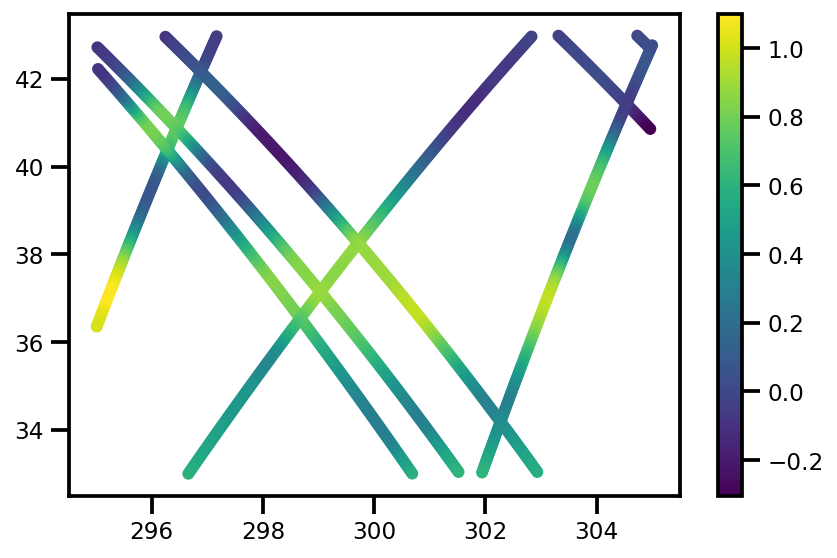

In [34]:
# plot demo
fig, ax = plot_demo_tracks(obs_ds_nadir, plot_time_coords, "ssh_obs")

plt.tight_layout()
plt.show()

In [36]:
obs_ds_jason

<xarray.Dataset>
Dimensions:  (time: 264665, cycle: 1)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-21T14:03:10.326319 ... 2012-12-02T...
Dimensions without coordinates: cycle
Data variables:
    lon      (time) float64 ...
    lat      (time) float64 ...
    x_al     (time) float32 ...
    ncycle   (time, cycle) timedelta64[ns] ...
    ssh_obs  (time) float64 ...
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [7]:
ds = xr.Dataset({
    'natl60': ref_ds.ssh,
    'oi': oi_ds.ssh_mod,
    'obs': obs_ds.ssh_mod,
})
ds


<xarray.Dataset>
Dimensions:  (lon: 201, lat: 201, time: 365)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    natl60   (time, lat, lon) float64 ...
    oi       (time, lat, lon) float64 ...
    obs      (time, lat, lon) float64 ...

## Viz

### SSH Field

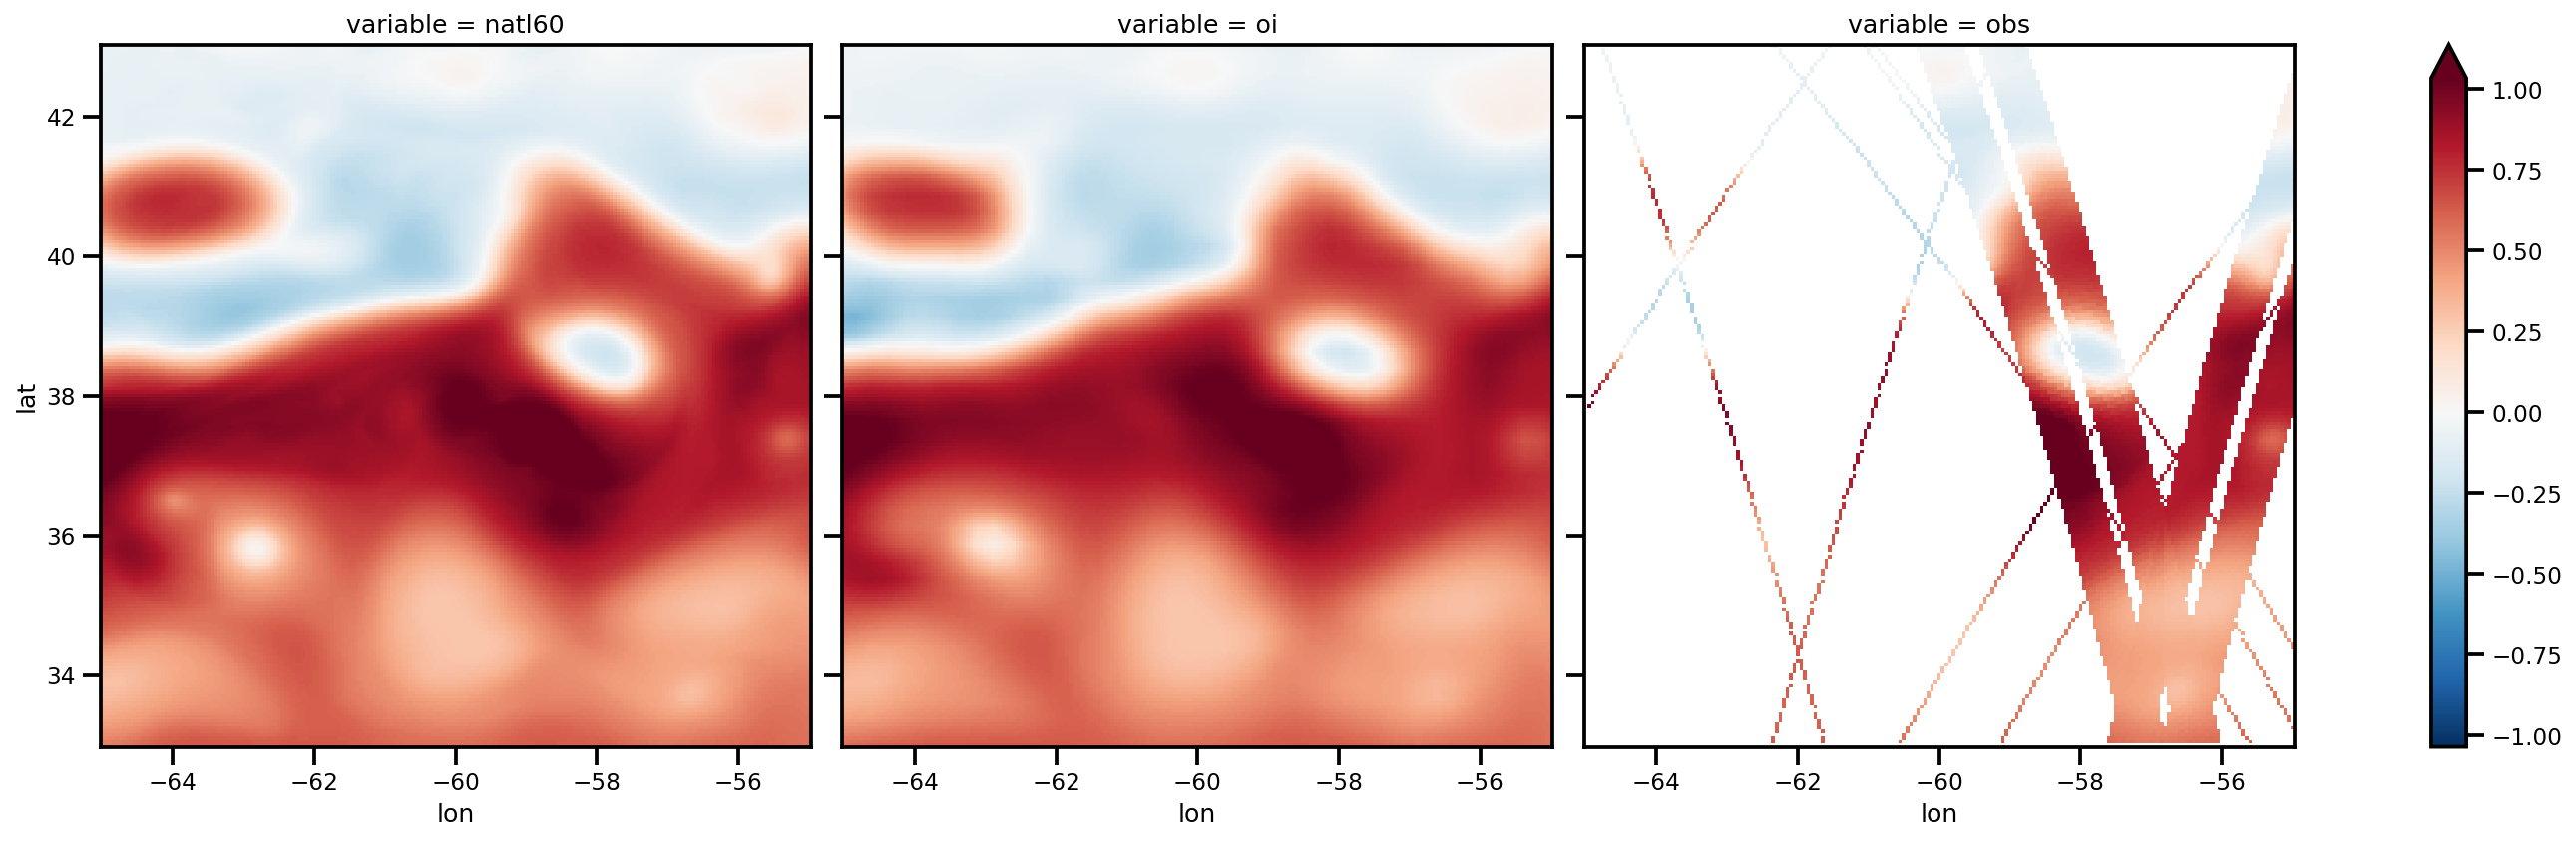

In [8]:
ds.to_array().isel(time=3).plot.pcolormesh(col='variable', figsize=(20, 6), robust=True)

### SSH Field Animation

In [9]:
# hv.extension('matplotlib')
# f = lambda da: da.isel(time=slice(25, 55, 1))
# ds = xr.Dataset({
#     'natl60': ref_ds.ssh,
#     'oi': oi_ds.ssh_mod,
#     'obs': obs_ds.ssh_mod,
# })
# # to_plot_ds = {"natl60": f(ref_ds.ssh), "oi": f(oi_ds.ssh_mod), "obs": f(obs_ds.ssh_mod)}
# # to_plot_ds = [f(ref_ds.ssh), f(oi_ds.ssh_mod), f(obs_ds.ssh_mod)]
# to_plot_ds = ds.isel(time=slice(25, 55, 1))
# clim = (
#     to_plot_ds[["natl60", "oi"]]
#     .to_array().pipe(lambda da: (da.quantile(0.005).item(), da.quantile(0.995).item()))
# )
# # clim=None
# images = hv.Layout([
#         hv.Dataset(to_plot_ds)
#         .to(hv.QuadMesh, ['lon', 'lat'], v).relabel(v)
#         .options(cmap='viridis', clim=clim)
#         for v in to_plot_ds
# ]).cols(3).opts(sublabel_format="")

# hv.output(images, holomap='gif', fps=2, dpi=125)

### Gradients

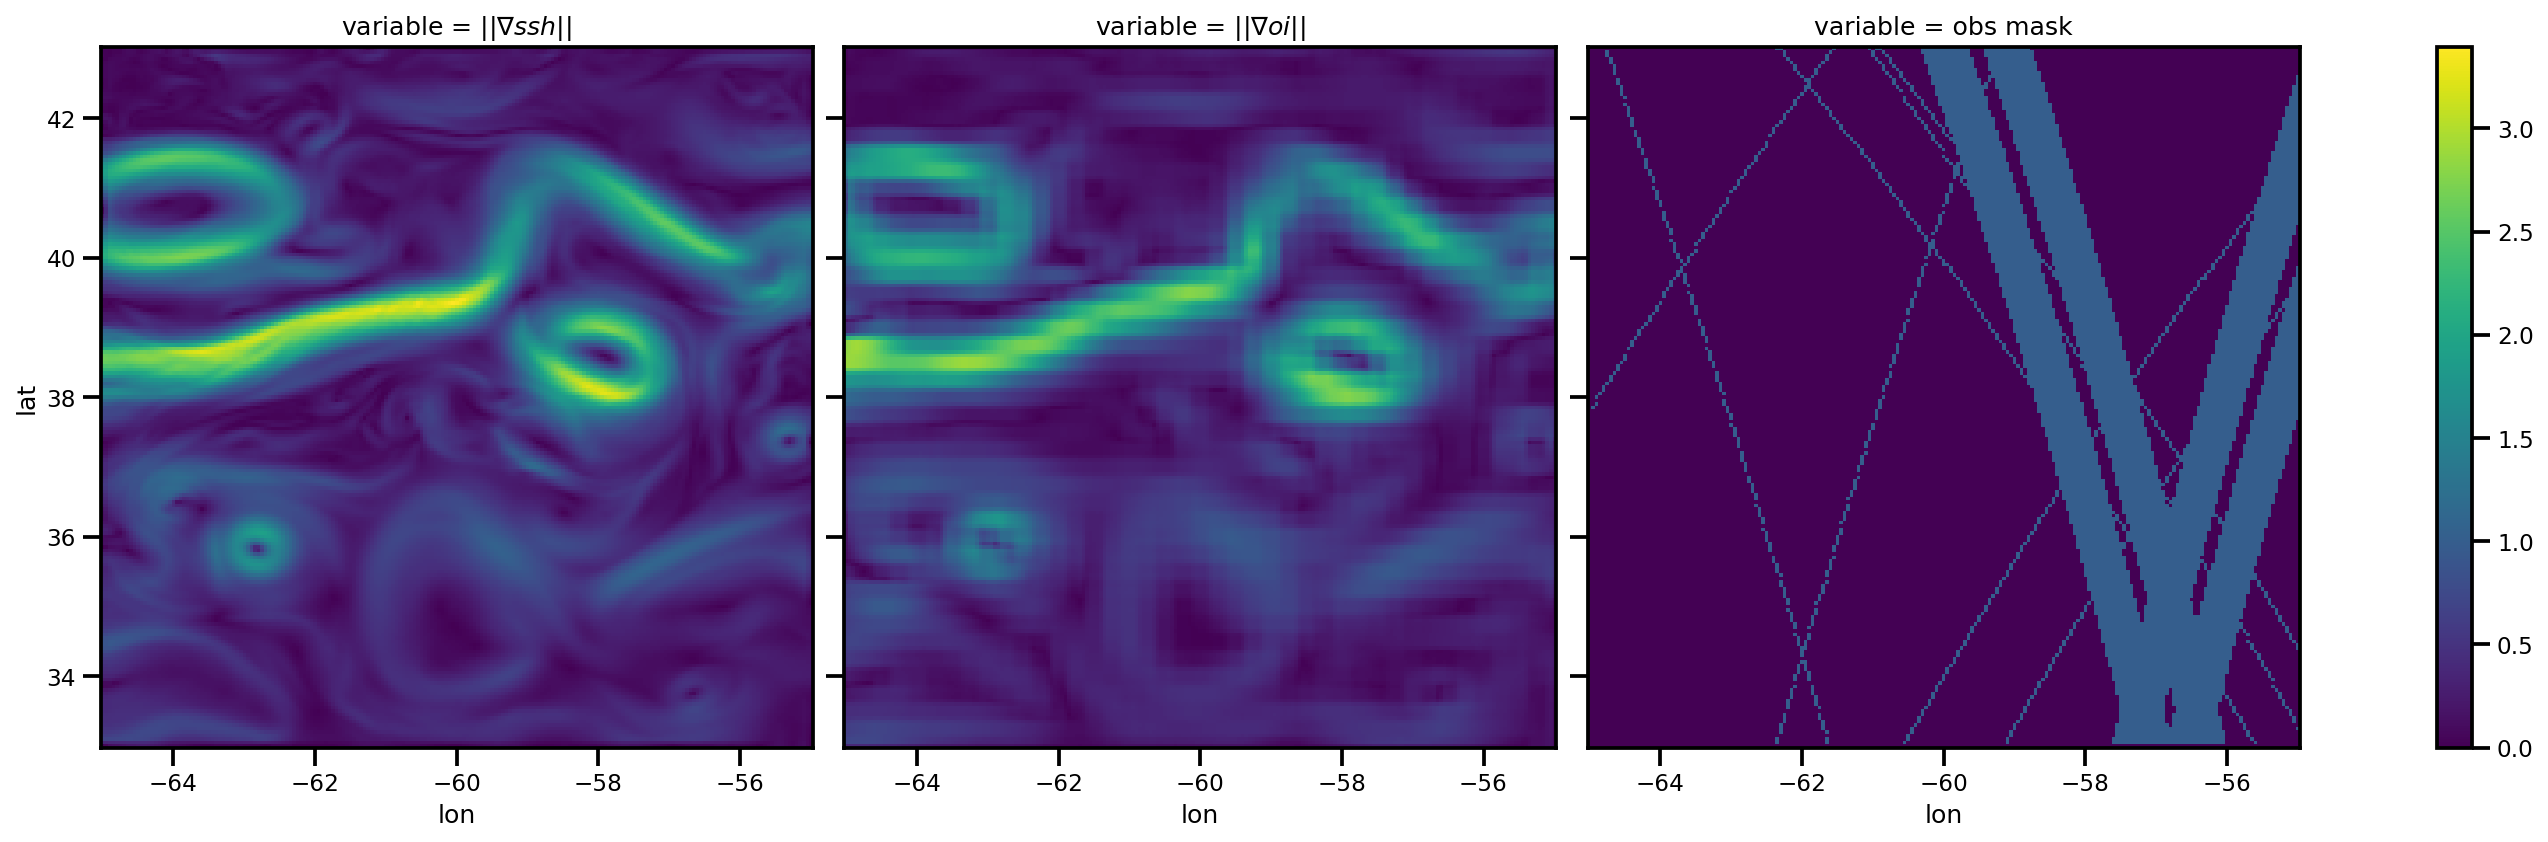

In [10]:
def sobel(da):
    dx = xr.apply_ufunc(lambda _da: ndimage.sobel(_da, -1), da)
    dy = xr.apply_ufunc(lambda _da: ndimage.sobel(_da, -2), da)
    return np.hypot(dx, dy)

grad_ds = xr.Dataset({
    r'||$\nabla ssh||$': ref_ds.ssh.pipe(sobel),
    r'||$\nabla oi||$': oi_ds.ssh_mod.pipe(sobel),
    'obs mask': np.isfinite(obs_ds.ssh_mod),
})
grad_ds.to_array().isel(time=3).plot.pcolormesh(col='variable', figsize=(20, 6), cmap='viridis')



### SSH Gradients Animation

In [11]:
# hv.extension('matplotlib')
# to_plot_ds = grad_ds.isel(time=slice(25, 55, 1))

# clim = (
#     to_plot_ds[[r'||$\nabla ssh||$', r'||$\nabla oi||$']]
#     .to_array().pipe(lambda da: (da.quantile(0.005).item(), da.quantile(0.995).item()))
# )
# images = hv.Layout([
#         hv.Dataset(to_plot_ds)
#         .to(hv.QuadMesh, ['lon', 'lat'], v).relabel(v)
#         .options(cmap='viridis',clim=clim)
#         for v in to_plot_ds
# ]).cols(3).opts(sublabel_format="")

# hv.output(images, holomap='gif', fps=2, dpi=125)

